# Pulling Stock Data
This is a Python notebook to analyze Stock data based on ticker symbols.


## 0. Programming in Python
Let's start by seeing how to make variables, functions, and logic in Python.

### Variables
Variables can take on many data types, from `'Strings'` to numbers (`0`), `True`/`False` and even functions.

Type **`x = 'Hello world!'`** in the box below, then press **`Shift + Enter`** to execute the code.

In [2]:
x = 'Hello world!'

Nothing happened... That's because we've only just created the variable `x`. Now to show the value of the variable, we need to type **`x`**. Again, press **`Shift + Enter`** to execute the code.

In [3]:
x

'Hello world!'

### Functions
Functions can take on any name - you get to choose - but the syntax for defining a function is always the same. Functions can also operate on one or more `variable` that gets defined when you initially create the function. These variables are a placeholder for what to do with any data that gets sent to the function when it is used.
- First, define the name of the function with **`def nameOfFunction():`**
- Then, if you want to send a variable to the function, put that variable name between the ().
- Lastly, on the next line, tab in one tab, and write the instructions for what the function will do.

Below, type **`def myFunction(y):`** on the first line, then hit `Enter` and type **`return y + 3`**.  Press **`Shift + Enter`** to save that function.

In the box below that, type **`myFunction(3)`** - what do you expect it to return when you press **`Shift + Enter`**?

In [4]:
def myFunction(y):
    return y + 3

In [5]:
myFunction(3)

6

### Logic
Logic is the last piece of the programming foundation; this will test some comparison, and depending on whether the comparison is `True` or `False`, one outcome will result.

We've put the basic structure in the box below, but you need to add a comparison in the `()` to test: e.g. **`(5 > 3)`** or **`('a' == 'a')`**. Press **`Shift + Enter`** to run the logic below.

In [6]:
if (5 > 9):
   print 'The comparison is True'
else:
   print 'The comparison is False'

The comparison is False


### Wrap Up
So that's it!  Variables, functions, and logic are the building blocks of programming in any language.

Now that you've got a handle on those, we're going to get a bit more complicated working with our data.

*Note: Just like above, you'll need to press `Shift + Enter` to run any code in an `In [ ]:` box.*

## <font color='green'>You're now finished with this section! Let your facilitators know, and have a break.</font>

![done](https://media.giphy.com/media/XreQmk7ETCak0/giphy.gif)

## 1. Sourcing Data
To begin working with our data, let's use an API called [Quandl](https://www.quandl.com) to bring in stock data.

We need to first `import quandl` to get the Quandl library of functions, then set our API key. The key for today is **`Byjzu4U8rmR1iEhZnp7V`** - copy and paste that between the `""` below.

In [7]:
!pip install quandl
import quandl
quandl.ApiConfig.api_key = "Byjzu4U8rmR1iEhZnp7V"

Now that we've got our connection to quandl, let's pull a single stock (`AAPL`) and store that in a variable called `data`.

Add **`WIKI/AAPL`** between the `""` below.

In [8]:
data = quandl.get("WIKI/AAPL", rows=5)

To find out the type of data, we can type **`print type(data)`**.

In [9]:
print type(data)

<class 'pandas.core.frame.DataFrame'>


And if we want to look at the data itself, we can type **`data`** below.

In [10]:
data

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-09-18,160.11,160.50,157.995,158.67,27939718.0,0.0,1.0,160.11,160.50,157.995,158.67,27939718.0
2017-09-19,159.51,159.77,158.440,158.73,20347352.0,0.0,1.0,159.51,159.77,158.440,158.73,20347352.0
2017-09-20,157.90,158.26,153.830,156.07,51693239.0,0.0,1.0,157.90,158.26,153.830,156.07,51693239.0
2017-09-21,155.80,155.80,152.750,153.39,36643382.0,0.0,1.0,155.80,155.80,152.750,153.39,36643382.0
2017-09-22,152.02,152.27,150.560,151.89,46114424.0,0.0,1.0,152.02,152.27,150.560,151.89,46114424.0


To assess the health of each stock, let's find the `Close` price for each stock. If you notice above, that's the 4th column.

Based on Quandl's [API documentation](https://docs.quandl.com/docs/time-series-2), we can extract just that column by adding **`.4`** after `WIKI/AAPL` to get `WIKI/AAPL.4`:

In [11]:
data = quandl.get("WIKI/AAPL", rows=5, collapse='monthly')
data

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1980-12-31,34.25,34.25,34.13,34.13,159600.0,0.0,1.0,0.503571,0.503571,0.501807,0.501807,8937600.0
1981-01-31,28.50,28.50,28.25,28.25,206200.0,0.0,1.0,0.419030,0.419030,0.415355,0.415355,11547200.0
1981-02-28,26.50,26.75,26.50,26.50,65900.0,0.0,1.0,0.389625,0.393300,0.389625,0.389625,3690400.0
1981-03-31,24.75,24.75,24.50,24.50,71400.0,0.0,1.0,0.363895,0.363895,0.360219,0.360219,3998400.0
1981-04-30,28.38,28.62,28.38,28.38,56300.0,0.0,1.0,0.417266,0.420795,0.417266,0.417266,3152800.0


That's great! But now we want to show data for the last 10 years.

First, we need to have Python tell us what today's date is. We've written most of this for you, but you need to add a line to output the value of `start_date`.

In [12]:
import datetime
start_date = (datetime.datetime.now() - datetime.timedelta(days=10*365)).strftime('%Y-%m-01')


Now we need to add a new parameter to our Quandl get request. After `collapse='monthly'`, add a comma and then **`start_date=start_date`** inside the parenthesis.

Then, to save space in the notebook, we're only going to show the top five rows of data using `data.head(5)`.

How could you show the top 10 rows instead?

In [13]:
data = quandl.get("WIKI/AAPL.4", rows=120, collapse='monthly')
data.head(5)

,Close
Date,
1980-12-31,34.13
1981-01-31,28.25
1981-02-28,26.50
1981-03-31,24.50
1981-04-30,28.38


Python comes with a number of great visualization tools built in.

Let's do a quick visualization of the data to see if it looks right:

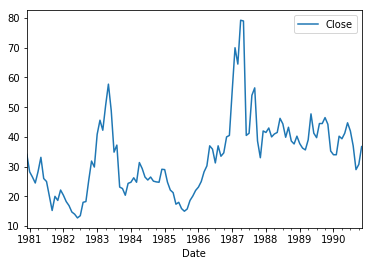

In [14]:
%matplotlib inline
!pip install mpld3 # install a package to let us zoon into our plots
import mpld3
mpld3.enable_notebook()

ax = data.plot()

Uh-oh! Looks like there's a problem: There's a big drop in AAPL stock in 2014!

Why?!  Well, a quick Google shows they [split their stock](https://www.washingtonpost.com/news/the-switch/wp/2014/06/09/apples-stock-price-just-dropped-more-than-500-a-share-but-dont-panic/). 

Luckily, Quandl has accounted for that. Instead of `Close`, we'll need to use the `Adjusted Close` price (column 11) from Quandl.

Modify the code below to get the 11th column instead of the 4th.

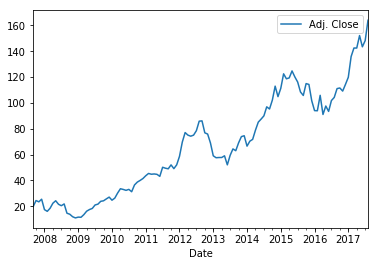

In [15]:
data = quandl.get("WIKI/AAPL.11", rows=120, collapse='monthly', start_date=start_date)
ax = data.plot()

Great! Let's now focus on the full portfolio.


## <font color='green'>You're now finished with this section! Let your facilitators know, and have a break.</font>

![done](https://media.giphy.com/media/3o7TKLpxzkbvjwEgSc/giphy.gif)

## 2. Sourcing more Data

Now that we have access to stock data, let's pull in our list of Warren's 2003 aquisitions.

First, we need to bring in the cleaned CSV file we exported from Open Refine, and store it as a variable. Let's call it `buffett`.

Now let's take the output of the Open Refine scrubbing step and replace `your_clean_csv.csv` with that output,  :

In [16]:
from pandas import read_csv
buffett = read_csv('WB_portfolio_for_Decoded-2017_0824-csv.csv')
buffett.head(5)

,COMPANY,TICKER,# OF SHARES,PRICE (8/24/2017),CITY,PURCHASE DATE,REGION,CEO,EMPLOYEES,WARREN COMMENT
0,Kraft Heinz (KHC),KHC,"325,634,818",$82.80,"Chicago, IL",9/27/2005,Central,Bernard Hees (2015–),"41,000 (2017)",Without a doubt
1,Wells Fargo (WFC),WFC,"467,987,270",$52.16,"San Francisco, CA",7/7/2002,West,"Timothy J. Sloan (Oct 12, 2016–)",NaN,It is decidedly so
2,Apple Inc. (AAPL),AAPL,"130,191,960",$159.27,"Cupertino, CA",9/23/2006,West,Tim Cook,NaN,Concentrate and ask again
3,The Coca Cola Company (KO),KO,"400,000,000",$45.41,"Atlanta, GA",12/10/2003,Southeast,"James Quincey (May 1, 2017–)",NaN,Reply hazy try again
4,American Express Co (AXP),AXP,"151,610,700",$85.36,"New York City, NY",6/2/2013,Northeast,Kenneth I. Chenault (Jan 2001–),NaN,It is decidedly so


Next we want to choose some of those stocks for our analysis. We could either type out the ticker symbol (e.g. `MSFT`) by hand, or we could refer to the `buffett` variable in order to select the ticker symbols. Let's choose the first 3 stocks from `buffett`. Replace `buffett[0:0]` with **`buffett[0:3]`**:

In [17]:
symbols = [ 'WIKI/%s.11' % ticker for ticker in buffett['TICKER'][0:3] ]
symbols

['WIKI/KHC.11', 'WIKI/WFC.11', 'WIKI/AAPL.11']

We can now load in the symbol data from quandl:

In [18]:
data = quandl.get(symbols, rows=121, collapse='monthly', start_date=start_date)
data.head(5)

,WIKI/KHC - Adj. Close,WIKI/WFC - Adj. Close,WIKI/AAPL - Adj. Close
Date,,,
2007-09-30,NaN,27.366091,19.723034
2007-10-31,NaN,26.129162,24.411222
2007-11-30,NaN,25.166378,23.417810
2007-12-31,NaN,23.428090,25.456041
2008-01-31,NaN,26.446814,17.395647


In [19]:
data.tail(5)

,WIKI/KHC - Adj. Close,WIKI/WFC - Adj. Close,WIKI/AAPL - Adj. Close
Date,,,
2017-05-31,91.538594,50.770724,152.142689
2017-06-30,85.005796,55.009891,143.438008
2017-07-31,86.832597,53.550505,148.248489
2017-08-31,80.750000,51.070000,164.000000
2017-09-30,77.520000,54.250000,151.890000


Let's clean up the column name to just their symbol name by removing `WIKI/` and ` - Close` from each column name.

We can iterate over the columns using the `for col in data.columns` syntax:

In [20]:
data.columns = [col.replace(' - Adj. Close','').replace('WIKI/','') for col in data.columns]
data.head(5)

,KHC,WFC,AAPL
Date,,,
2007-09-30,NaN,27.366091,19.723034
2007-10-31,NaN,26.129162,24.411222
2007-11-30,NaN,25.166378,23.417810
2007-12-31,NaN,23.428090,25.456041
2008-01-31,NaN,26.446814,17.395647


Let's have another quick look at the data, to make sure everything looks good.

Add the code to plot the `data` (hint: you've used this code above already):

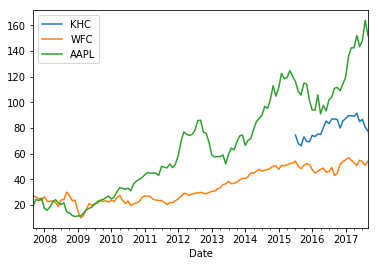

In [21]:
data.plot()

Explore the data by using the icons in the bottom left corner of the plot. 

It looks like we have some incomplete data.

Further investigation reveals that we only have data for Kraft Heinz (KHC) from July 2015 to September 2017, and we're missing September 2017 for WFC and AAPL. We'll need to remember this for later, as this might affect our analysis.

## <font color='green'>You're now finished with this section! Let your facilitators know, and have a break.</font>

![done](https://media.giphy.com/media/26FL2NwYBOq3Z6C6Q/giphy.gif)

## 3. Analysis

Data analysis is all about answering questions. In this case Warren has one question - what will the prices of his stocks be in the future?

To answer that question we are going to build our own Time Series Forecasting model from the ground up. This model will use the historic data that we have collected to forecast predictions for the future. We'll test it on one stock's data as we go.

Before we get started, we need to extract all of the data for one stock as a `list` of numbers (it's easier to work with them this way). 

**Complete the code below to extract the data for Apple stock:**

In [23]:
apple = data['AAPL'].values

Now we begin building.

If we have a number that jumps up and down over time, as the Apple stock price does, what might be a good way to guess where it will next be? Taking an average price might be a good starting point.

Complete the function below to calculate the average price of Apple stock over the whole `series`. Some built-in functions that might help are:
- `sum(x)`, which will find the total of all values in x
- `len(x)`, which will find the number of elements in x
- `+`, `-`, `*`, `/`, the basic arithmetic operators

Write your code in place of `#TODO`:

In [24]:
def average(series):
    return sum(series)/len(series)

# Print prediction
pred1 = average(apple)
print "\nNext month's Apple stock should be worth: ", pred1


Next month's Apple stock should be worth:  67.1615495168


We have our prediction. How can we judge whether that's a good prediction or not?

One way is to run our model on all but the last data point of our `series` (using the `series[:-1]` syntax) and see how well it predicts the true value. This technique is called **cross validation** and is used frequently in data analysis and machine learning. 

Let's see how well it works as a prediction for next month's value by visualizing it. Run the code below to import a couple of tools and plot Apple's stock with our new <font color='red'>prediction</font> against the <font color='blue'>Apple data</font> :


This month's stock price should be: 66.4554790961
It was actually: 151.89
56.2476271669 %


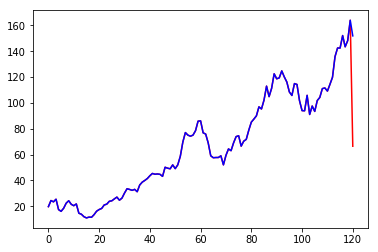

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Recalculate the predicted stock price for _this_ month:
pred1 = average(apple[:-1]) # don't include this month's actual value
print "This month's stock price should be:", pred1
print "It was actually:", apple[-1]
results1 = np.append(apple[:-1], pred1) # append all but the last points with our predicted point
_,ax = plt.subplots()
_,_,_ = ax.plot(results1, color = "red"), ax.plot(apple, color = "blue"), plt.show() # 

Yikes. The true value for last month's price was **`156`**, so we're about $90 off!

The problem is that we are taking an average over the entire time series, and that hasn't taken in to account the change in the *level* of our prices over time. One way we can solve this is by taking a 'moving average' that only takes an average of the last *n* stocks. It is called a 'moving average' as the window of values that it uses shifts along as we get new data:

![movingavg](https://user-images.githubusercontent.com/534681/30615807-16ee0d0e-9d5e-11e7-834a-6728edc8ad24.png)

Complete the code in the `moving_average` function below to take a recent average of the last 5 months of Apple's stock price.

*HINT: `x[-n:]` only uses the last n numbers in a `list` x*

This month's stock price should be:  150.063120124
It was actually: 151.89


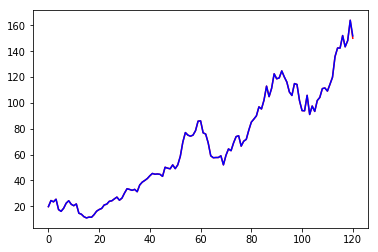

In [26]:
def  moving_average(series, n):
    return average(series[-n:])

# Print and plot prediction
pred2 = moving_average(apple[:-1], 5)
print "This month's stock price should be: ", pred2
print "It was actually:", apple[-1]

results2 = np.append(apple[:-1], pred2)
_,ax = plt.subplots()
_,_,_ = ax.plot(results2, color = "red"), ax.plot(apple, color = "blue"), plt.show()

That looks better - you might want to zoom in to the top right corner to get a better look.

However, we're giving equal importance to all of the recent stock prices in our model.

To prioritize the most recent, we can multiply each of the last *n* stock prices by a number, called a weight, and then take an average. **What combination of weights work best?**

*NOTE: these weights should increase in the direction of time and always add up to 1!*

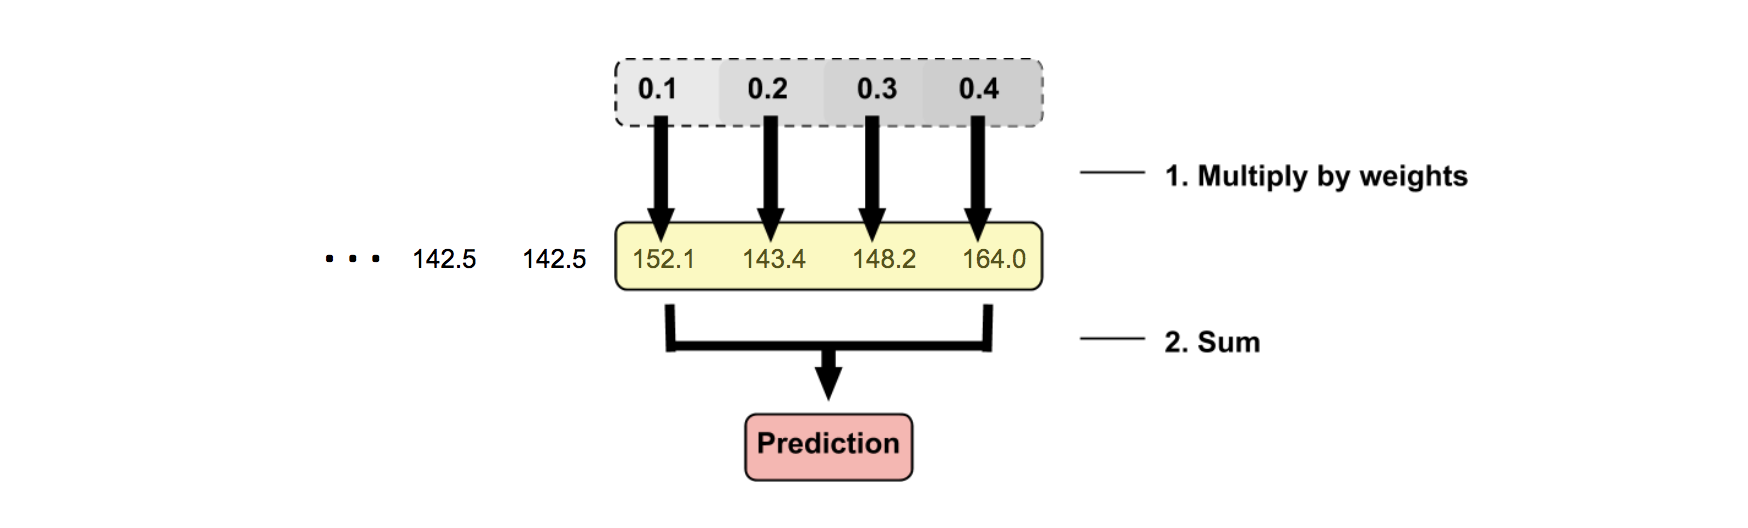

This month's stock should be:  153.976417255
It was actually: 151.89


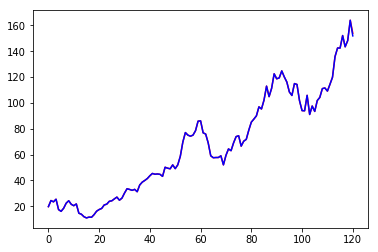

In [27]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weights = [0.1,0.2,0.3,0.4]

# Print and plot prediction
pred3 = weighted_average(apple[:-1], weights)
print "This month's stock should be: ", pred3
print "It was actually:", apple[-1]
results3 = np.append(apple[:-1], pred3)
_,ax = plt.subplots()
_,_,_ = ax.plot(results3, color = "red"), ax.plot(apple, color = "blue"), plt.show()

You've now trained your model to an accurate prediction of the future. But will your weights always predict Apple stock this well?

Probably not, because this model only is only using the last few stock prices, and throwing the rest away. What if we want to use all the data?

One clever trick, devised by mathematicians Poisson, Holt and Roberts, is to overlap lots of small moving average windows, taking the output (weighted average) of one window as a data point in the next. Specifically, the windows are of size two, using weights $\alpha$ and $(1 - \alpha)$ (remember, weights have to add up to 1, so they can both be defined by one variable). This is process is *recursive*, as it take the output from one step as the input of the next, starting from the first pair of values and repeating through all values.

If you'd like to see that in a formula, it is:

$$\hat{y}_t = \alpha y_t + (1 - \alpha)\hat{y}_{t-1}$$

where $\hat{y}_t$ is the predicted price at time *t*, and $\alpha$ is the one value we use to calculate the two weights, $\alpha$ and $(1 - \alpha)$.

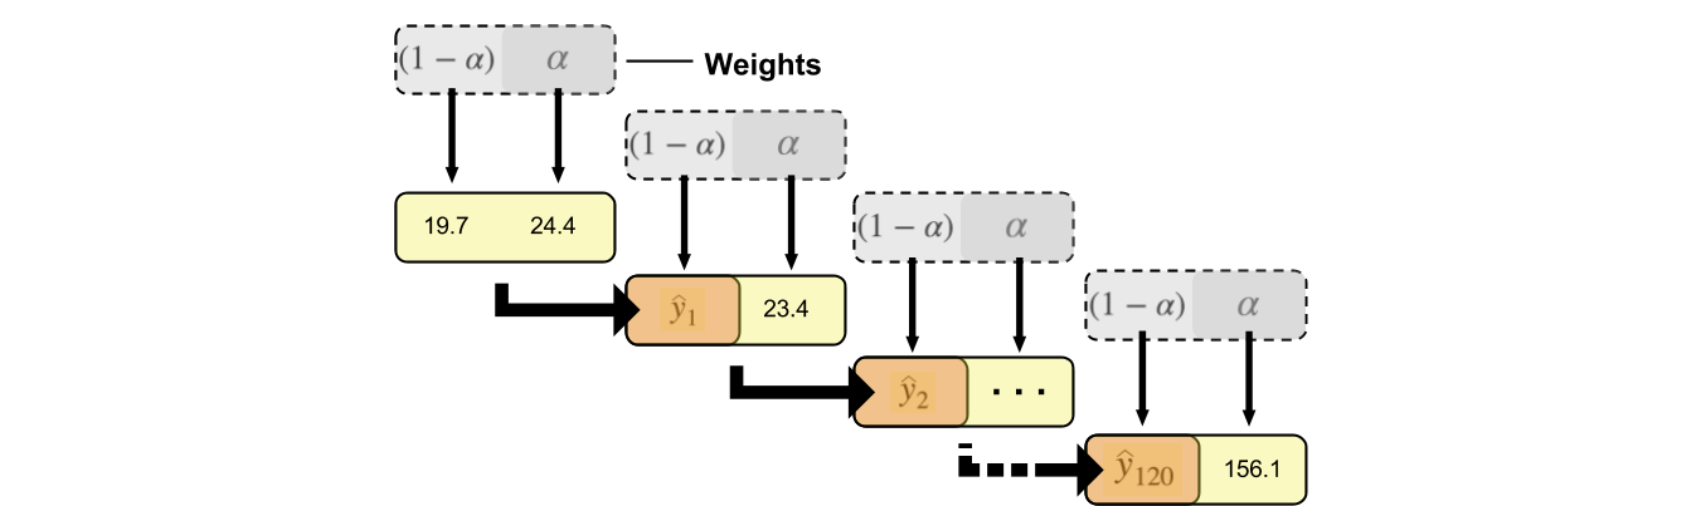

Before moving on, find the answer to the following questions:

1. What does this *parameter*   $\alpha$   control? Experiment with different values to find out.
2. How far in to the future can this model accurately predict?

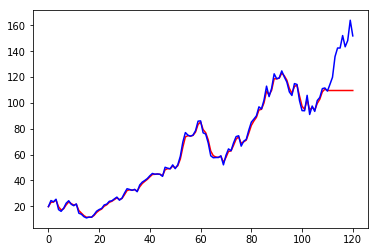

In [28]:
def exponential_smoothing(series, alpha, predictions):
    smoothed = [series[0]] # first value is same as series
    for n in range(1, len(series) + predictions):
        if n >= len(series): # we are forecasting
            value = smoothed[-1]
        else:
            value = series[n]
        smoothed.append(alpha * value + (1 - alpha) * smoothed[n-1]) 
    return smoothed

alpha = 0.7
predictions = 10 # how many predictions do you want to make?

# Print and plot prediction
pred4_full = exponential_smoothing(apple[:-predictions], alpha = alpha, predictions = predictions)
_,ax = plt.subplots()
_,_,_ = ax.plot(pred4_full, color = "red"), ax.plot(apple, color = "blue"), plt.show()

As you will have seen from your experiments, the blue line is our true data and the red line is our *model* of that data. The good thing about models is that we can use them to model the unseen future, as well as the known past. 

However, at the moment our model isn't doing a great job on the future part. 

The main issue seems to be that it only tracks the values of the data. That is because our model looks only at the **level** of the values, so the best it can do is give us the same values back. We need it to also consider the **trend** of the data, which is the size of the jump between adjacent values.

Before, with exponential smoothing, we iteratively updated the level. Now, with *Double* Exponential Smoothing (DES), we iteratively update the level *and* trend in the same way, and then add them together to make our prediction. This introduces a second parameter, $\beta$ (beta), which defines the two weights used to itereatively update the trend.

The weights, `alpha` and `beta` have been preassigned some values below, but the model is poor. **Your task is to find values for these parameters that give a good prediction of the future.**

*NOTE: the `test_points` variable cuts your model's data short, so that you can 'test' how well your model predicts unknown data. This is currently set at 5 - lower values make things easier and higher values make it much harder! Bonus points for generating a good fit using 7 test points or more.*

In [46]:
# Define double exponential smoothing
def d_e_s(series, alpha, beta, predictions):
    smoothed = [series[0]]
    for n in range(1, len(series)+ predictions):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
            value = smoothed[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        smoothed.append(level+trend)
    return smoothed

# Define a function to plot the model
def plot_d_e_s(series, test_points, forecast_points, alpha=0.1, beta=0.5):
    pred5_full = d_e_s(series[:-test_points], alpha = alpha, beta = beta, predictions = test_points*forecast_points)
    _,ax = plt.subplots()
    _,_,_ = ax.plot(pred5_full, color = "red"), ax.plot(apple, color = "blue"), plt.show()

# Create an interactive plot with apple stock
interact(plot_d_e_s, series=fixed(apple), test_points=5, forecast_points=3, alpha=(0,2,0.1), beta=(0,2,0.1))

<function __main__.plot_d_e_s>

Congratulations! We have built a model that can predict the future.

This is a simplistic introduction to time series analysis, although these methods are the foundation to many of the cutting edge techniques used currently. If you'd like to like to investigate further, we recommend following the introduction here:

https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c

## <font color='green'>You're now finished with this section! Let your facilitators know, and have a break.</font>

![done](https://media.giphy.com/media/R6aNZ3Uc1aR1K/giphy.gif)

## 4. Preparing for Visualization

Let's get our data ready for a more snazzy visualization.

Based on the [D3.js show reel](https://bl.ocks.org/mbostock/1256572), we need the data to be arranged like this:

```
symbol,date,price
MSFT,Jan 2000,39.81
MSFT,Feb 2000,36.35
MSFT,Mar 2000,43.22
MSFT,Apr 2000,28.37
MSFT,May 2000,25.45```

### 4.1 Replotting with forecasts

First, we need to calculate our predictions for each stock (using the $\alpha$ and $\beta$ values you've chosen) and append them to the end of our dataframe. We will predict 3 months ahead:

In [41]:
!pip install --upgrade pandas # upgrade pandas
import pandas as pd

data = data.reindex(pd.date_range("2007-09-30", "2017-12-31", freq = '1M'), fill_value="NaN")

alpha = 0.3
beta = 0.9

for i, column in enumerate(data):
    if column == 'KHC': # select only the range of dates for which we have data
        stock = data[column].iloc[94:-3].values
    else:
        stock = data[column].iloc[:-4].values
    forecast = d_e_s(stock, alpha = alpha, beta = beta, predictions = 3) # create our forecast
    
    col_forecast = pd.Series(forecast[-3:], index = pd.date_range("2017-10-31", "2017-12-31", freq = '1M'))
    data[column].iloc[-3:] = col_forecast
    
data.tail(6)

Requirement already up-to-date: pandas in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.7.0 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from pandas)
Requirement already up-to-date: python-dateutil in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from pandas)
Requirement already up-to-date: pytz>=2011k in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from python-dateutil->pandas)


,KHC,WFC,AAPL
2017-07-31,86.8326,53.5505,148.248
2017-08-31,80.75,51.07,164
2017-09-30,77.52,54.25,151.89
2017-10-31,71.9614,48.0552,164.453
2017-11-30,67.3709,46.4604,167.238
2017-12-31,62.7805,44.8656,170.022


How did your model fair on the other stocks? Let's visualize the results!

Below, we create two overlapping plots, one with the existing data and one with our forecasts, marked in red. So that we can see the relative trends, we'll only look at the range where we have data for KHC:

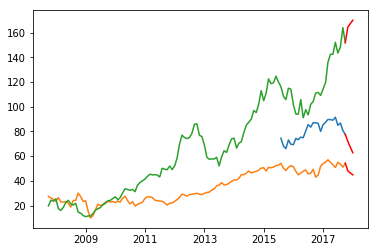

In [53]:
fig, ax = plt.subplots()
ax.plot(data.iloc[:-3])
ax.plot(data.iloc[-4:], color = "Red")

What do you notice about our forecasts?

### 4.2 Exporting for further visualization

Next, we want to rearrange all of the data to be more like what we need for D3. Python comes with a function called `unstack()` that does just that!

Below, make a variable called `datalist` and set it equal to `data.unstack()`.

Then show the top 10 rows of the datalist. (Hint, you've used this type of function before)

Almost there! We've done the hard work, now we just need it in a CSV format.

We've written this bit of code to clean the data a bit more and to output the data in a comma-separated value format.

In [ ]:
csv = datalist.to_csv(header=True, index_label=['symbol','date','price'], date_format='%b %Y', index=True)
csv = csv.replace("price,0","price") # remove addition of ',0' on first line
print csv

We could copy & paste this into a new CSV file for our D3.js visualization, or we could write code to do that for us.

To make the downloadable file, we've got to bring in a library called `base64` which will encode the file. Then we use that to create the file and add a bit of HTML to make it so we can download the file.

In [ ]:
import base64
from IPython.display import HTML

b64 = base64.b64encode(csv.encode())
payload = b64.decode()
html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{filename}</a>'
html = html.format(payload=payload,title="stocks.csv",filename="stocks.csv")
HTML(html)


## <font color='green'>You're done!</font>

![done](https://media.giphy.com/media/15BuyagtKucHm/giphy.gif)